This project is going to take the multichannel delay, apply the hadamard and check that the result is the same as Cipriani's FDN before attempting to optimize.

Credit to https://github.com/radoslawregula/reverb-algorithms/blob/master/fdn_prototype.pym for the damping filter and help with design.

In [1]:
import librosa
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import math
import soundfile as sf
import numpy.typing as npt
from numba import jit, prange
from numba import vectorize, int32, int64, float32, float64
import timeit
from tqdm.auto import tqdm
from numba_progress import ProgressBar

In [2]:
%config InlineBackend.figure_formats = ['svg']
plt.style.use('dark_background')

In [3]:
SAMPLE_RATE = 44100

In [4]:
@jit("float64[:](float64[:], int32, boolean)", nopython=True, fastmath=False)
def feedforward_delay(x, loop_time=1, milliseconds=False):
    
    M = (loop_time / 1000) * SAMPLE_RATE if milliseconds else loop_time
    M = int(M) if (M > 0) else 1
    
    d = np.zeros(M) # wrap this buffer and add last value to input array.
    p = 0 # delay buffer index
    y = np.zeros(x.size) # output buffer
    
    for i in range(x.size):
        
        # p = p % M
        
        y[i] = d[p % M] 
        d[p % M] = x[i] # will not here the result until p reaches the beginning of the delay buffer d.
        # p = p + 1 if (p < M-1) else 0
        p += 1
        
    return y

In [5]:
@jit("float64[:](float64[:], float64, float64)", nopython=True, fastmath=False)
def onepole(input, freq=200, sample_rate=SAMPLE_RATE):
    
    output = np.zeros((input.shape[-1]))
    
    x = np.exp(-2.0*np.pi*freq/sample_rate)
    
    a0 = 1-x
    b1 = -x
    
    tmp = 0
    
    for i in range(len(output)):
        output[i] = a0 * input[i] - b1*tmp
        tmp = output[i]
        
    return output

In [6]:
def prime(x, y):
    prime_list = []
    for i in range(x, y):
        if i == 0 or i == 1:
            continue
        else:
            for j in range(2, int(i/2)+1):
                if i % j == 0:
                    break
            else:
                prime_list.append(i)
    return prime_list

In [7]:
# @vectorize([int32(int32, float64, float64, float64, int32[:])])
def del_list(n=16, min_dist=1., max_dist=100., curve=1, prime_list=np.array([0])):
    
    """
    create a list of delay times, with a minimum and maximum distance.
    
    n: number of delay times
    curve: exponential value to multiply each delay time by
    """
    
    # divided by speed of sound multiplied by milliseconds.
    min_dist  /= 344
    min_dist *= 1000.
    
    max_dist  /= 344.
    max_dist *= 1000.
    
    l = np.power(np.linspace(0, 1, n), curve)
    l = (((min_dist + (l * (max_dist - min_dist))) / 1000) * SAMPLE_RATE) + 0.5
    
    current = prime_list[(np.abs(prime_list - l[0])).argmin()]
    
    for i in range(n):
        
        index = (np.abs(prime_list - l[i])).argmin()
        
        l[i] = prime_list[index]
        
        while (current >= l[i]):
            index += 1
            l[i] = prime_list[index]
        
        current = l[i]
    
    return l.astype(np.int32)

In [8]:
def filter_list(n=16, min=200, max=1200, curve=3.5):
    l = np.power(np.linspace(0, 1, n), curve)
    l = min + (l * (max - min))
    return l

[ 200.          200.07650337  200.86553688  203.57770876  209.79243197
  221.3833433   240.47715405  269.42625408  310.78872077  367.31288056
  441.92491287  537.71860864  657.94672179  806.01353829  985.46840082
 1200.        ]


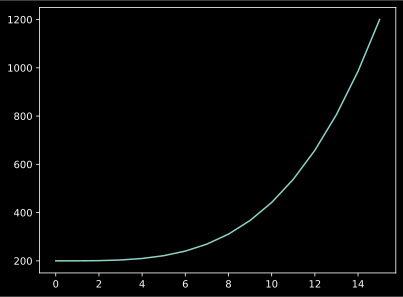

In [9]:
# ok now I need to apply that list to a list of frequencies in the reverb!
print(filter_list())
plt.plot(filter_list())

In [10]:
def plot(x, title=None):
    x_axis = np.arange(0, x.shape[-1])
    fig = plt.figure()
    fig.suptitle(title)
    gs = fig.add_gridspec(x.shape[0], hspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        ax.plot(x_axis, x[i])
        ax.label_outer()

In [11]:
prime_list = prime(0, 30000)

In [12]:
@vectorize([float64(float64)])
def t60(duration_in_samples):
    return np.exp(np.log(0.001) / duration_in_samples)

In [13]:
@vectorize([float64(float64)])
def t60_time(multiplier):
    return np.log(0.001) / np.log(multiplier)

In [14]:
# make array's c contiuguous.

@jit("float64[:](float64[:], float64, int32[:], float64[:, :], float64[:])", nopython=True, fastmath=True, parallel=False)
def simple_fdn(input, decay, l, H, freqs):
    
    N = l.shape[0]
    
    # empty array to calculate each t60 value.
    decay_ms = np.zeros(N)
    
    # print gain calculation for each delay line as a function of t60
    # convert ms to samples and then divide by loop_time in samples then take t60.
    for i in range(N):
        decay_ms[i] = t60(((decay/1000) * SAMPLE_RATE) / l[i])
        
    extra_time_in_samples = int(t60_time(decay_ms[-1]) * l[-1])
    # print(extra_time_in_samples)
    
    x = np.zeros((N, input.shape[-1] + extra_time_in_samples))
    x[:, :input.shape[-1]] = input

    y = np.zeros(x.shape)
    f_y = np.zeros(x.shape)
    output = np.zeros(x.shape)
    feedback = np.zeros(x.shape)
    feedback[:, :] = x[:, :]
    
    # it's almost as though I should skip the first feedforward?
    # I still get the early delayed signals without being mixed with the others.
    
    num_iterations = int(np.ceil((44100 / l[0])  * (decay / 1000)))
    
    for j in prange(num_iterations):
        for i in prange(N):
            y[i] = feedforward_delay(feedback[i] * decay_ms[i], l[i], milliseconds=False)
            f_y[i] = onepole(y[i], freq=freqs[i], sample_rate=SAMPLE_RATE)
            output[i] += f_y[i]
        feedback = H @ f_y
    y = np.sum(output, axis=0)
    
    return y * (1 / np.max(np.abs(y)))

C:\Users\bwhat\AppData\Local\Temp\ipykernel_15828\1613572856.py:38: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  feedback = H @ f_y


In [15]:
# unit impulse for testing.
x = np.zeros(1)
x[0] = 1.0

In [18]:
# haven't yet implemented filter list to each delay loop.
decay = 5000
N = 16
H = scipy.linalg.hadamard(N) * 0.25
l = del_list(n=N, min_dist=10., max_dist=100., curve=1.809, prime_list=prime_list)
freqs = filter_list(1200, 18000, 1.809) # ok but what's the logic behind the filters? just test it out.
y = simple_fdn(x, decay, l, H, freqs)

(220501,)


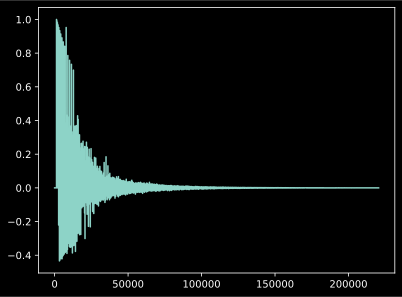

In [19]:
plt.plot(y)
print(y.shape)
Audio(y, rate=44100)